In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask

In [2]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\seasonal'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\seasonal\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
seasons = ['DJF', 'MAM', 'JJA', 'SON']
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [4]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds
var='pr'

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [5]:
df_stat = pd.read_csv(r'Data\Datasets\amz\seasonal\stations_ts.csv', index_col=0)
import xskillscore as xs
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr', 'season']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])

from Data.utils.evaluation import calculate_kge, calculate_nse
pixel_dict = {}
for i , name in enumerate(datasets_names):
    ds = ds_dict[name].copy()
    
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    # Step 3: Compute the mean rainfall value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin','season'])['pr'].mean().reset_index()
    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((4,len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)
    # Step 5: Fill the DataArray with the computed mean rainfall values for each year
    for _, row in grid_cells.iterrows():
        season_idx = np.where(data['season'].unique() == row['season'])[0][0]
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        #idx to int
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)
        empty_grid[season_idx, year_idx, lat_idx - 1, lon_idx - 1] = row['pr']
    # Step 6: Create an xarray DataArray from the result with the year dimension
    season_coords = data['season'].unique()
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('season','year', 'lat', 'lon'),
                                coords={'season':season_coords,'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    # and the year dimension representing the yearseries.
    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.pr >= 0)

In [6]:
df = pd.DataFrame()
for name in datasets_names:
    ds = pixel_dict[name]
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    dff['Region'] = dff['Region'].replace(regions_replace)
    df = df.append(dff)
df = df[['pr', 'Region', 'Dataset','season','year']].dropna().reset_index(drop=True)
#df = df.rename(columns={'mask':'region'})


C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3063715632.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3063715632.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3063715632.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3063715632.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3063715632.py:7: FutureWarning: The frame.append method is dep

In [7]:
df_stat = pd.read_csv(r'Data\Datasets\amz\seasonal\stations_ts.csv', index_col=0)
df_stat = df_stat.merge(stations[['Code', 'Region']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr'}).drop('Code', axis=1)
#df_stat = df_stat.groupby(['Region','season', 'year']).mean().reset_index().drop('Code', axis=1)
df_stat['Dataset'] = 'Stations'
df = df.append(df_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\2191450422.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_stat)


In [ ]:
df

C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\255841929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.rename(columns={'season': 'Season'}, inplace=True)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

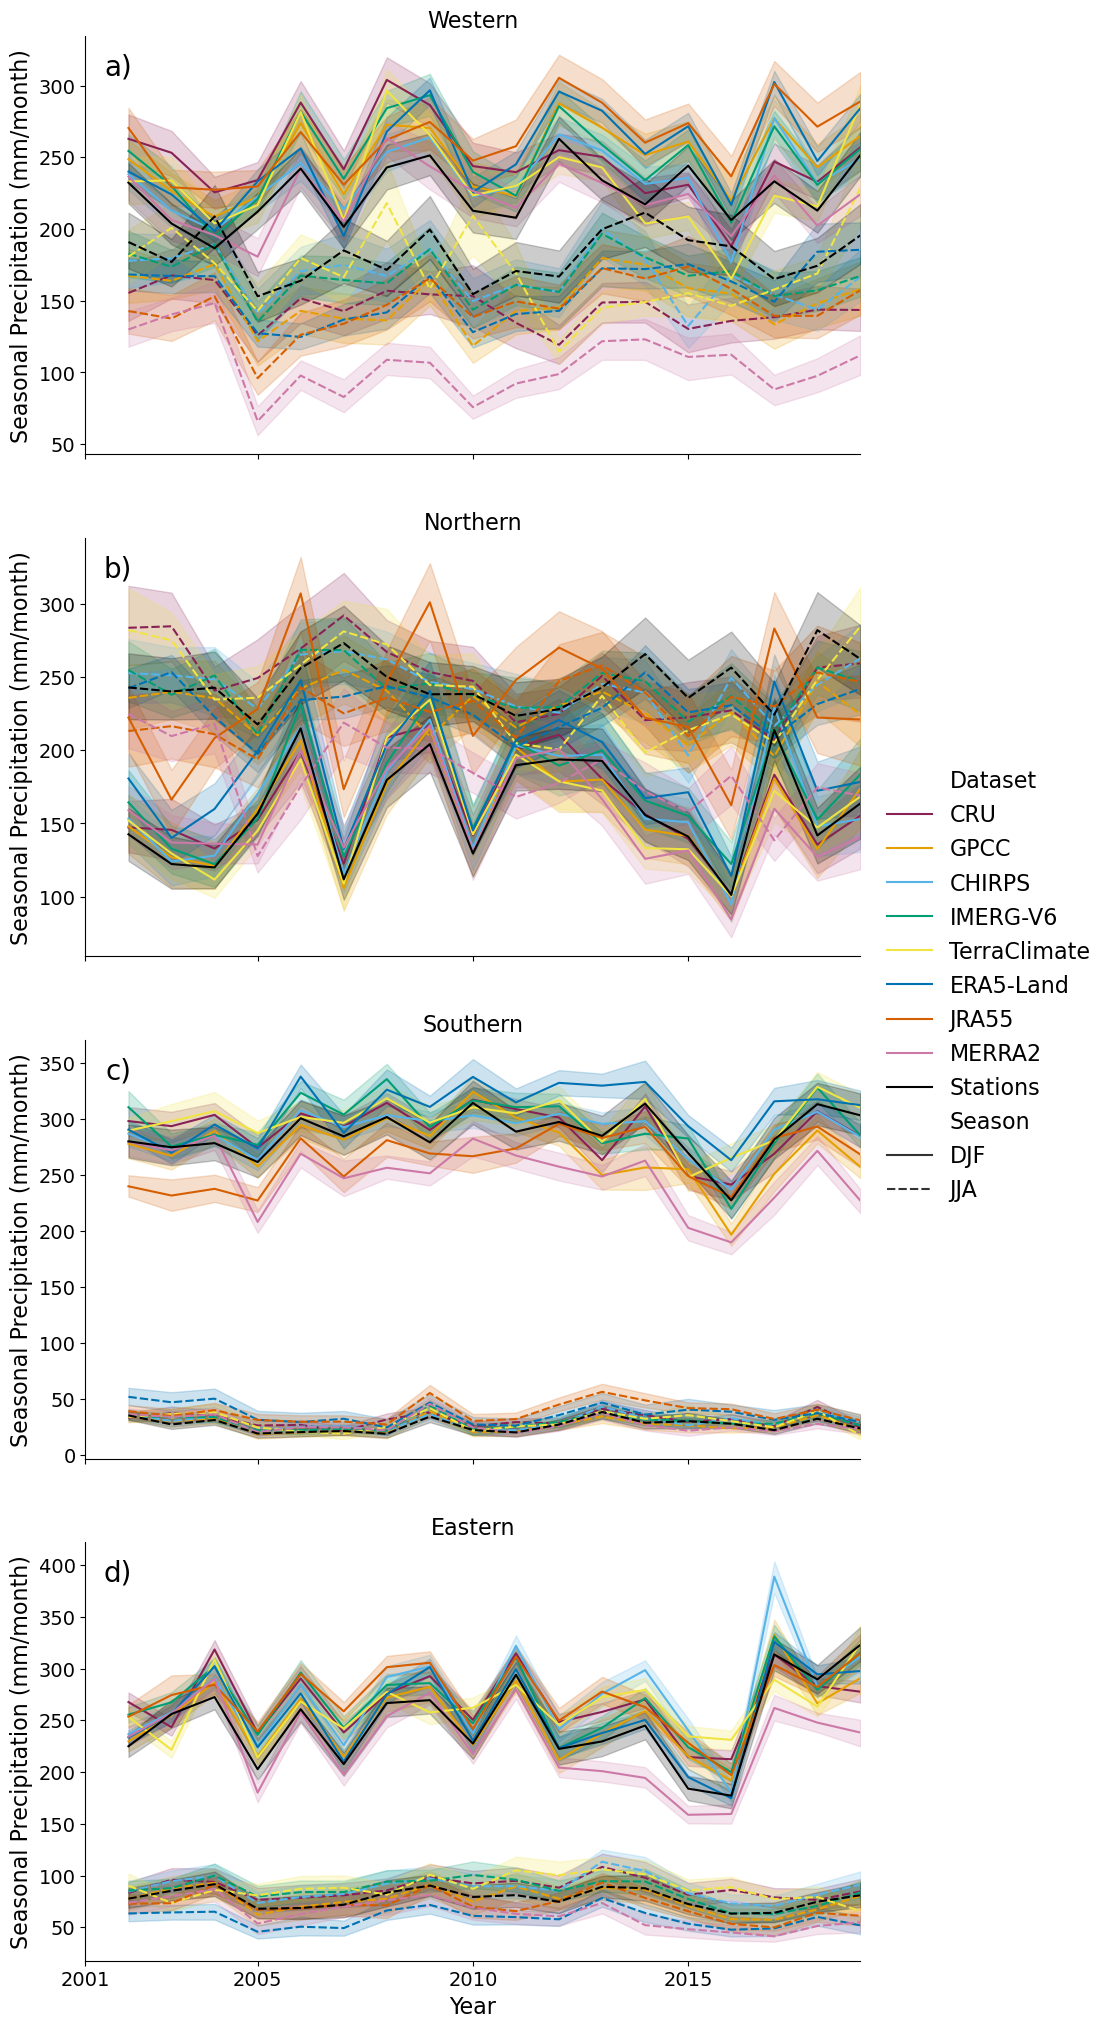

In [12]:
df_plot = df[df.season.isin(['DJF', 'JJA'])]
df_plot.rename(columns={'season': 'Season'}, inplace=True)
letters_ts = ['a)', 'b)', 'c)', 'd)']
#a lineplot for each region
fig, axes = plt.subplots(4,1, figsize=(10, 25), sharex=True)
axes = axes.flatten()
for i, region in enumerate(regions_list):
    sns.lineplot(data=df_plot[df_plot.Region==region], x='year', y='pr', hue='Dataset', style='Season', ax=axes[i], palette=wong_b, hue_order=hue_order, legend=True)
    axes[i].set_title(region, fontsize=16)
    axes[i].set_ylabel('Seasonal Precipitation (mm/month)', fontsize=16)
    axes[i].set_xlabel('Year', fontsize=16)
    axes[i].text(0.06,0.96,  letters_ts[i], transform=axes[i].transAxes,  fontsize=20, va='top', ha='right')
    axes[i].set_xticks([2001, 2005,2010, 2015, 2020])
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    axes[i].set_xlim(2001, 2019)
    sns.despine(ax=axes[i], top=True, right=True, left=False, bottom=False)
#put legend outside the plot in the right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=16, frameon=False, ncol=1)
plt.tight_layout

# PDF

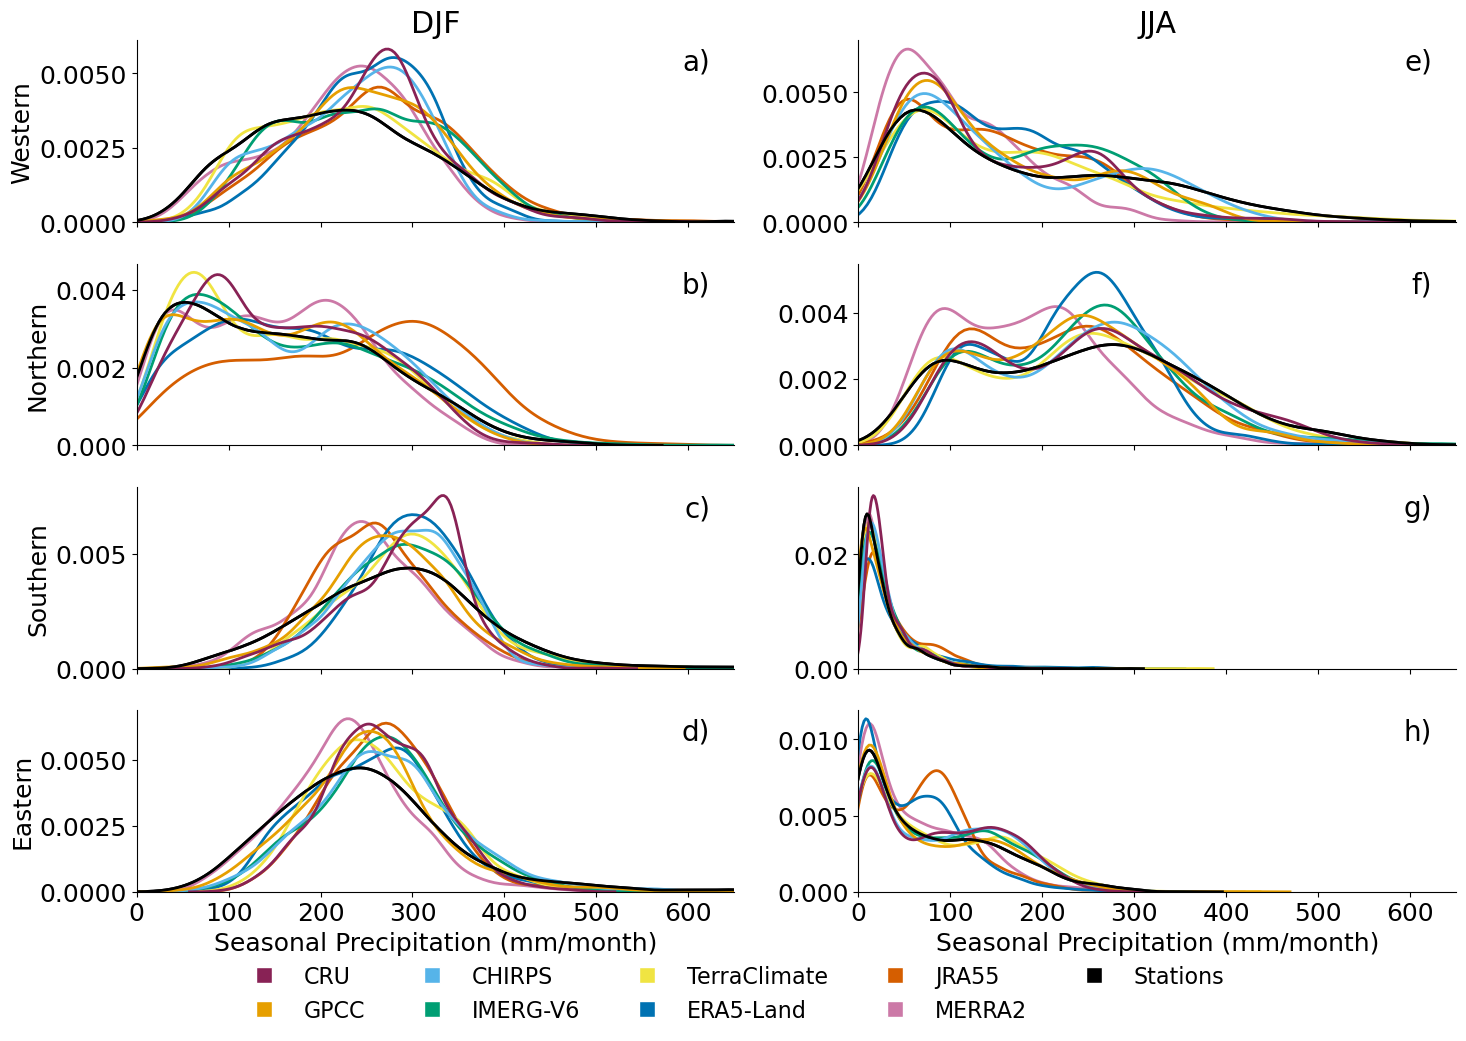

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10), sharex='col')
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_reg = df_plot[df_plot.Region==region]
    for j, season in enumerate(['DJF', 'JJA']):
        df_reg_season = df_reg[df_reg.season==season]
        sns.kdeplot(data=df_reg_season, ax=axs[i, j], x='pr', hue='Dataset', fill=False, common_norm=False, linewidth=2,palette=wong_b, hue_order=hue_order, legend=False)
        sns.kdeplot(data=df_reg_season[df_reg_season.Dataset=='Stations'], x='pr', fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, j], legend=False)
        axs[i, j].set_title('')
        axs[i, j].set_xlabel('Seasonal Precipitation (mm/month)')
        axs[i, j].set_xlim(0, 650)
        if i == 0:
            axs[i, j].set_title(season)
    axs[i, 0].text(0.96,0.96,  letters_ts[i], transform=axs[i, 0].transAxes,  fontsize=20, va='top', ha='right')
    axs[i, 1].text(0.96,0.96,  letters_pdf[i], transform=axs[i, 1].transAxes,  fontsize=20, va='top', ha='right')   
    #    
    axs[i, 1].set_ylabel('')
    axs[i, 0].set_ylabel(region)
    #despine
    sns.despine(ax=axs[i, 0], top=True, right=True, left=False, bottom=False)
    sns.despine(ax=axs[i, 1], top=True, right=True, left=False, bottom=False)

fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)

plt.tight_layout()

# taylor

In [13]:
from Data.utils.taylor import *
from scipy.stats import pearsonr
df_mean = df.groupby(['year', 'Region', 'Dataset', 'season']).mean().reset_index()

#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
std_ref = []

for k, season in enumerate(['DJF', 'JJA']):
    df_sea = df_mean[df_mean['season'] == season]
    for region in ['Western', 'Northern', 'Southern', 'Eastern']:
        df_region = df_sea[df_sea['Region'] == region]
        df_station = df_region[df_region['Dataset'] == 'Stations']
        for dataset in datasets_names:
            df_ds = df_region[df_region['Dataset'] == dataset]
            # do correlation
            corr = pearsonr(df_ds.pr.values, df_station.pr.values)[0].round(2)
            df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'season':season}, ignore_index=True)
            std_ref.append(df_station.pr.values.std())

C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3329940788.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'season':season}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3329940788.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'season':season}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_10092\3329940788.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Datase

In [14]:
marker_list = ['*','.' ]
marker_legend = [Line2D([0], [0],  marker='*', color='w', label='DJF', markerfacecolor='black', markersize=12),
                  Line2D([0], [0],  marker='.', color='w', label='JJA', markerfacecolor='black', markersize=12)]
marker_legend = marker_legend +  legend_elements_b


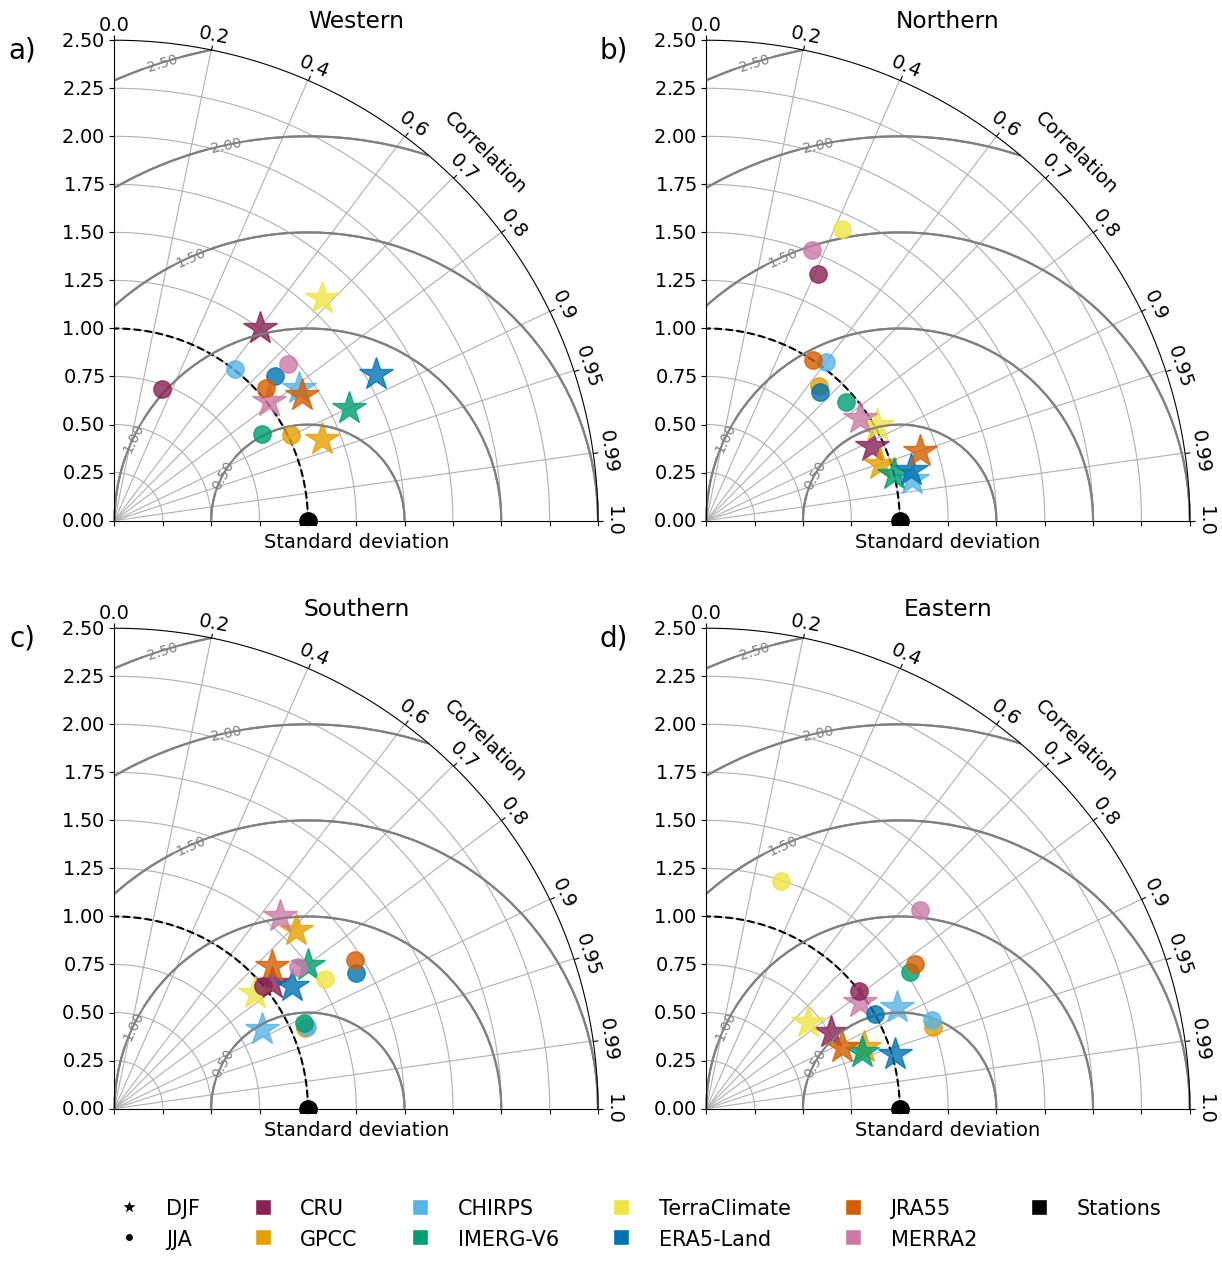

In [16]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 14})
mss = 25
for i, region in enumerate(['Western', 'Northern', 'Southern', 'Eastern']):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 2.5), mss=mss)

# Create a figure and a gridspec layout
    for k, season in enumerate(['DJF', 'JJA']):
        df_corr_sea = df_corr[df_corr['season'] == season]
        df_reg = df_corr_sea[df_corr_sea.Region == region]
        # Add samples to Taylor diagram
        contours = dia.add_contours(colors='0.5')
        for j, name in enumerate(datasets_names):
            df_set = df_reg[df_reg['Dataset'] == name]
            std = df_set['sd'].values[0]
            corr = df_set['corr'].values[0]
            dia.add_sample(std, corr, marker=marker_list[k], ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name, alpha=0.8)

    
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region) 
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    

    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(handles=marker_legend, bbox_to_anchor=(0.5, 0), loc='lower center', ncol=6, frameon=False, fontsize=15)
#legend in the middle outside of the plot
#plt.tight_layout()

# point to pixel

In [ ]:
df_stat = pd.read_csv(r'Data\Datasets\amz\seasonal\stations_ts.csv', index_col=0)
import xskillscore as xs
df_stat = df_stat.merge(stations[['Code','geometry']], on='Code')
df_stat = df_stat.rename(columns={'Total':'pr'})
# Step 1: Convert GeoDataFrame to DataFrame with point coordinates, rainfall values, and timestamps
data = df_stat[['geometry', 'year', 'pr', 'season']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])


In [ ]:
from Data.utils.evaluation import calculate_kge, calculate_nse
metrics_dict = {}
for i , name in enumerate(datasets_names):
    ds = ds_dict[name].copy()
    
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    # Step 3: Compute the mean rainfall value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin','season'])['pr'].mean().reset_index()
    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((4,len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)
    # Step 5: Fill the DataArray with the computed mean rainfall values for each year
    for _, row in grid_cells.iterrows():
        season_idx = np.where(data['season'].unique() == row['season'])[0][0]
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        #idx to int
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)
        empty_grid[season_idx, year_idx, lat_idx - 1, lon_idx - 1] = row['pr']
    # Step 6: Create an xarray DataArray from the result with the year dimension
    season_coords = data['season'].unique()
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('season','year', 'lat', 'lon'),
                                coords={'season':season_coords,'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    # and the year dimension representing the yearseries.
    ds['stat'] = data_array
    dss = xr.corr(ds.stat, ds.pr, dim='year').to_dataset(name='corr')
    dss['rmse'] = xs.rmse(ds.stat, ds.pr, dim='year')
    dss['mae'] = xs.mae(ds.stat, ds.pr, dim='year')
    dss['mape'] = xs.mape(ds.stat, ds.pr, dim='year')*100
    dss['r2'] = xs.r2(ds.stat, ds.pr, dim='year')
    dss['kge'] = calculate_kge(ds.stat, ds.pr, dim='year')
    dss['nse'] = calculate_nse(ds.stat, ds.pr, dim='year')
    dss['mape'] =  dss['mape'].where(~((dss['mape']>5000) & ((dss['mape'] != np.nan))),5000)
    dss['Region'] = ds['Region']
    metrics_dict[name] = dss

In [ ]:
df_metrics = pd.DataFrame()
for name in datasets_names:
    ds = metrics_dict[name]
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df_metrics = df_metrics.append(dff)
df_metrics = df_metrics[['lat','lon','corr', 'rmse', 'mae', 'mape', 'kge','nse', 'Region', 'Dataset', 'season']]
df_metrics['Region'] = df_metrics['Region'].replace(regions_replace)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21692\3452700568.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21692\3452700568.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21692\3452700568.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21692\3452700568.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2169

In [ ]:
data = metrics_dict['TerraClimate'].to_dataframe().reset_index().dropna()
ds = ds_dict['MERRA2'].copy()
metrics = ['rmse', 'mape', 'corr', 'kge','nse']
metrics_dict_05 = {}

for i, name in enumerate(datasets_names):
    data = metrics_dict[name].to_dataframe().reset_index().dropna()
    ds = ds_dict['MERRA2'].copy()
    data_arrays_dict = {}
    # Step 2: Loop through each metric
    for var in metrics:
        # Step 3: Assign each point to the grid cells of the 'ds' DataArray
        ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
        data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
        data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

        # Step 4: Compute the mean value for each grid cell and each metric
        grid_cells = data.groupby(['lat_bin', 'lon_bin','season'])[var].mean().reset_index()

        # Step 5: Create an empty DataArray with NaN values
        empty_grid = np.full((4,len(ds_grid_lat), len(ds_grid_lon)), np.nan)

        # Step 6: Fill the DataArray with the computed mean values for each metric
        for _, row in grid_cells.iterrows():
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            season_idx = np.where(data['season'].unique() == row['season'])[0][0]
            empty_grid[season_idx,lat_idx - 1, lon_idx - 1] = row[var]
        season_coords = data['season'].unique()

        # Step 7: Create an xarray DataArray from the result with the lat and lon dimensions
        data_array = xr.DataArray(empty_grid,
                                  dims=('season','lat', 'lon'),
                                  coords={'season':season_coords,'lat': ds_grid_lat, 'lon': ds_grid_lon}).rename(var)

        # Add the DataArray to the dictionary
        data_arrays_dict[var] = data_array

    # Step 8: Create an xarray Dataset containing all the DataArrays
    dataset = xr.Dataset(data_vars=data_arrays_dict)
    metrics_dict_05[name] = dataset


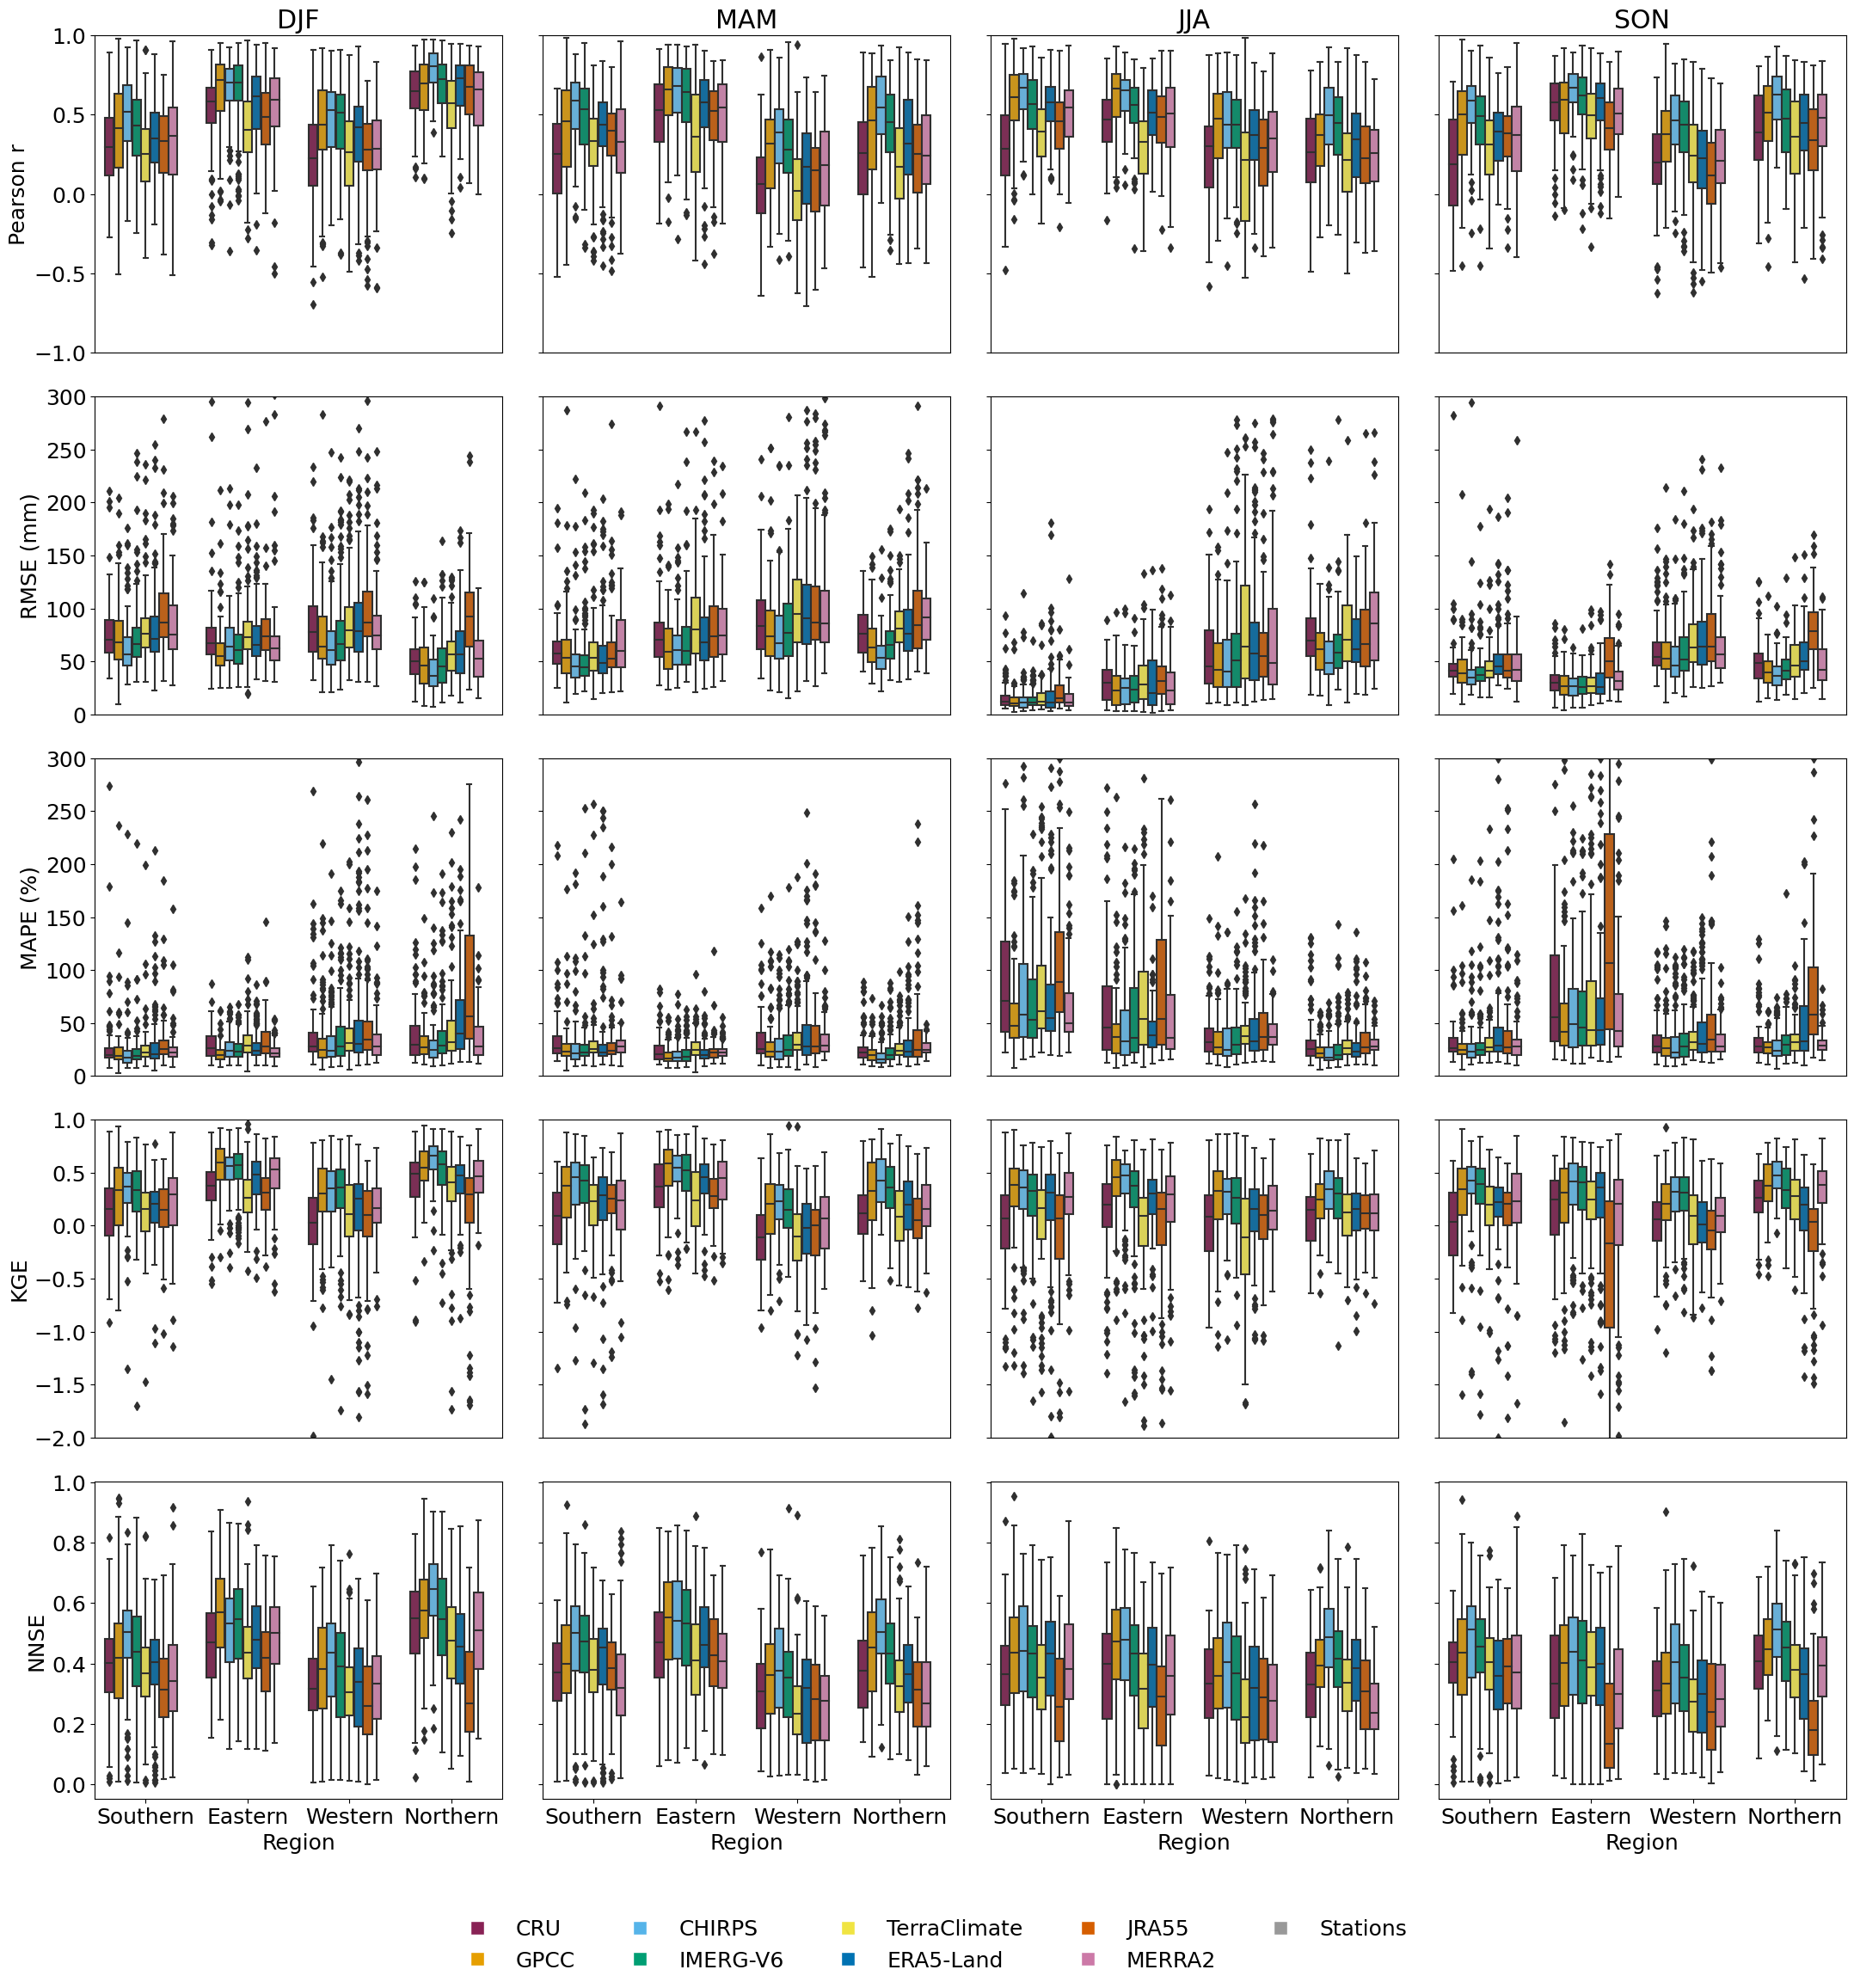

In [ ]:
df_metrics['nnse'] = 1/(2-df_metrics['nse'])
metrics_plot = ['corr','rmse', 'mape', 'kge','nnse']
metrics_label = ['Pearson r', 'RMSE (mm)', 'MAPE (%)', 'KGE', 'NNSE']

fig, axes = plt.subplots(len(metrics_plot), 4, figsize = (22, 22), sharey='row')
for i, metric in enumerate(metrics_plot):
    for j, season in enumerate(seasons):
        #box plot
        df_season = df_metrics[df_metrics.season == season]
        sns.boxplot( y=metric,x="Region", data=df_season, ax=axes[i,j], hue_order=hue_order, palette=wong, hue='Dataset').get_legend().remove()
        #axes[i,j].set_title(season)

        if j == 0:
            axes[i,j].set_ylabel(metrics_label[i])
        else:
            axes[i,j].set_ylabel('')
        if i == 0:
            axes[i,j].set_title(season)
        if i != 4:
            axes[i,j].set_xlabel('')
            axes[i,j].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
axes[0,0].set_ylim(-1,1)
axes[1,0].set_ylim(0,300)
axes[2,0].set_ylim(0,300)
axes[3,0].set_ylim(-2,1)
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

plt.tight_layout()

C:\Users\luisg\AppData\Local\Temp\ipykernel_15712\1446058723.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


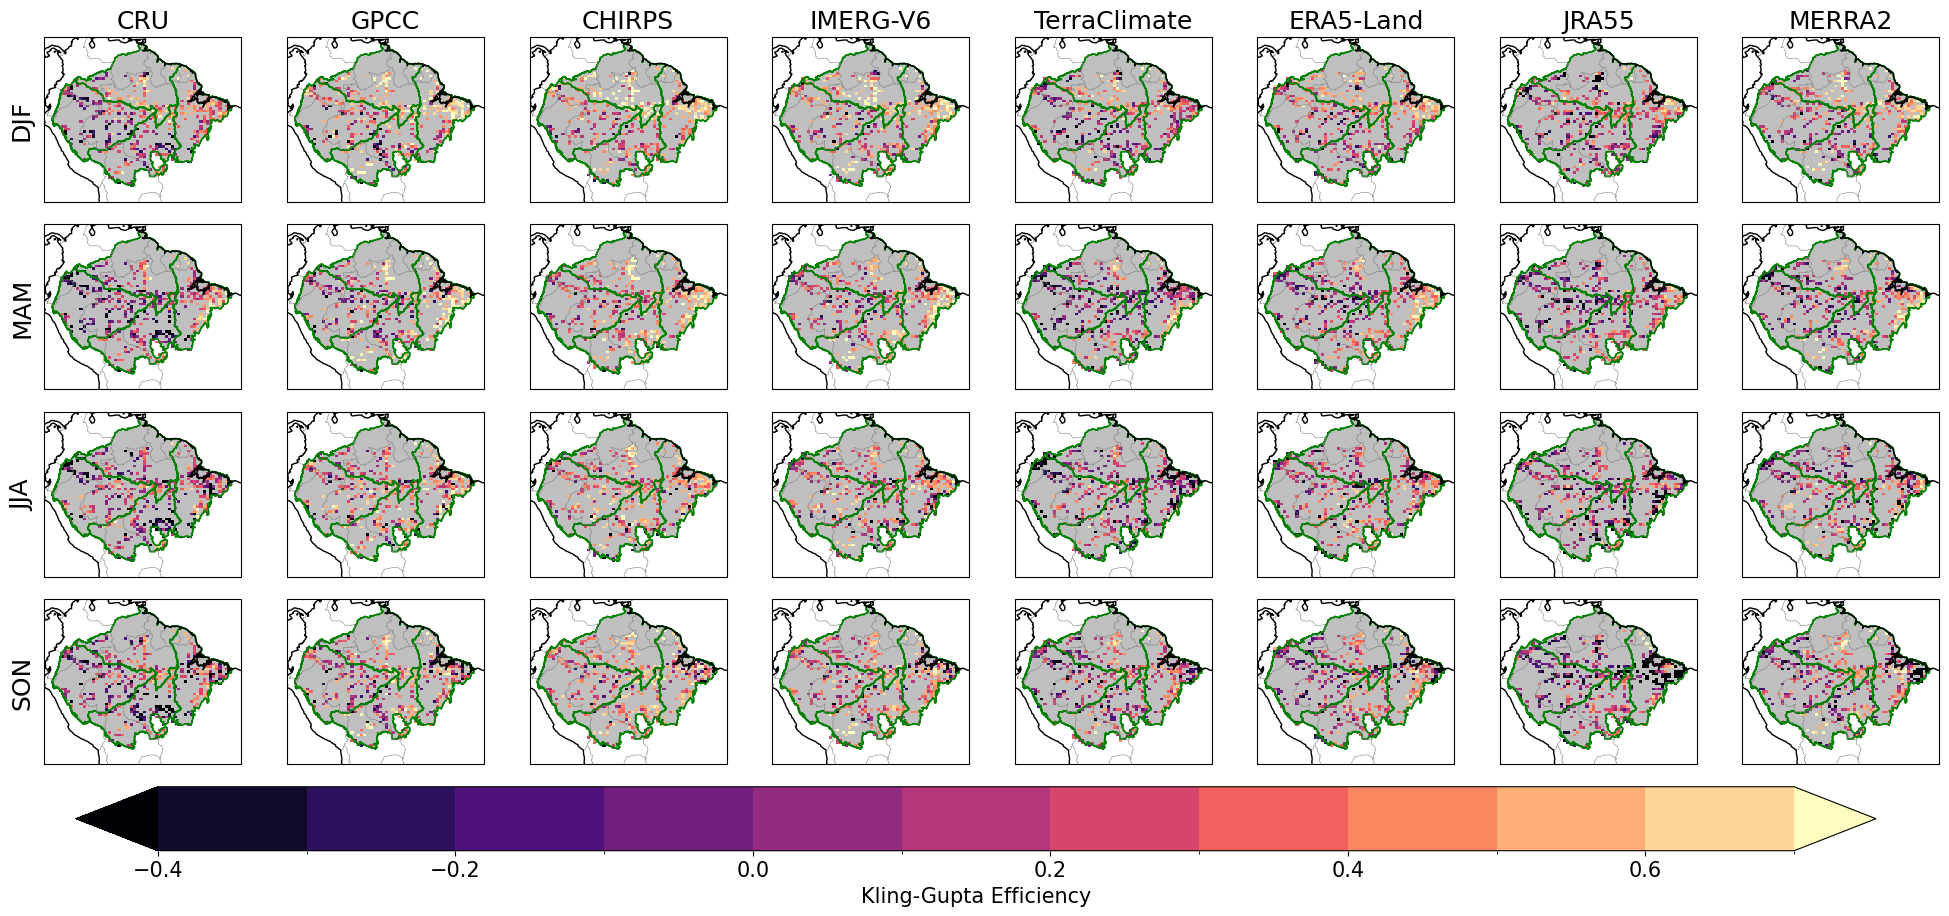

In [ ]:
vmin = -0.4
vmax = 0.7
levels = 12
cmap =  mpl.cm.magma
extend_cbar = 'both'
var = 'kge'
var_stat = 'kge'
label_cbar = 'Kling-Gupta Efficiency'
proj = ccrs.Mercator()

#####
bounds = np.linspace(vmin,vmax,levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]
plt.rcParams.update({'font.size': 15})


#plot each dataset and each season
fig, axes = plt.subplots(ncols=len(datasets), nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.08, 0.9, 0.08])

fig.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar)
for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = metrics_dict_05[name]
        ds.sel(season=seasons[j])[var].plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels, extend=extend_cbar)
        ax.add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='green', linewidth=1, zorder=-30,alpha=0.5)

        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.set_extent([-81, -42, -20, 11])
        ax.coastlines()

        if i == 0:
            ax.set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            ax.set_title(datasets_names[i], fontsize=18)


plt.tight_layout()
# trend

In [ ]:
vmin = 0
vmax = 70
levels = 8
cmap =  mpl.cm.inferno
extend_cbar = 'max'
var = 'mape'
var_stat = 'Total'
label_cbar = 'Mean Absolute Percentage Error(%)'
proj = ccrs.Mercator()
levels = 10
#####
bounds = np.linspace(vmin,vmax,levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
seasons = ['DJF', 'MAM', 'JJA', 'SON']
extend = [-81, -42, -20, 11]


C:\Users\luisg\AppData\Local\Temp\ipykernel_15712\4144201114.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


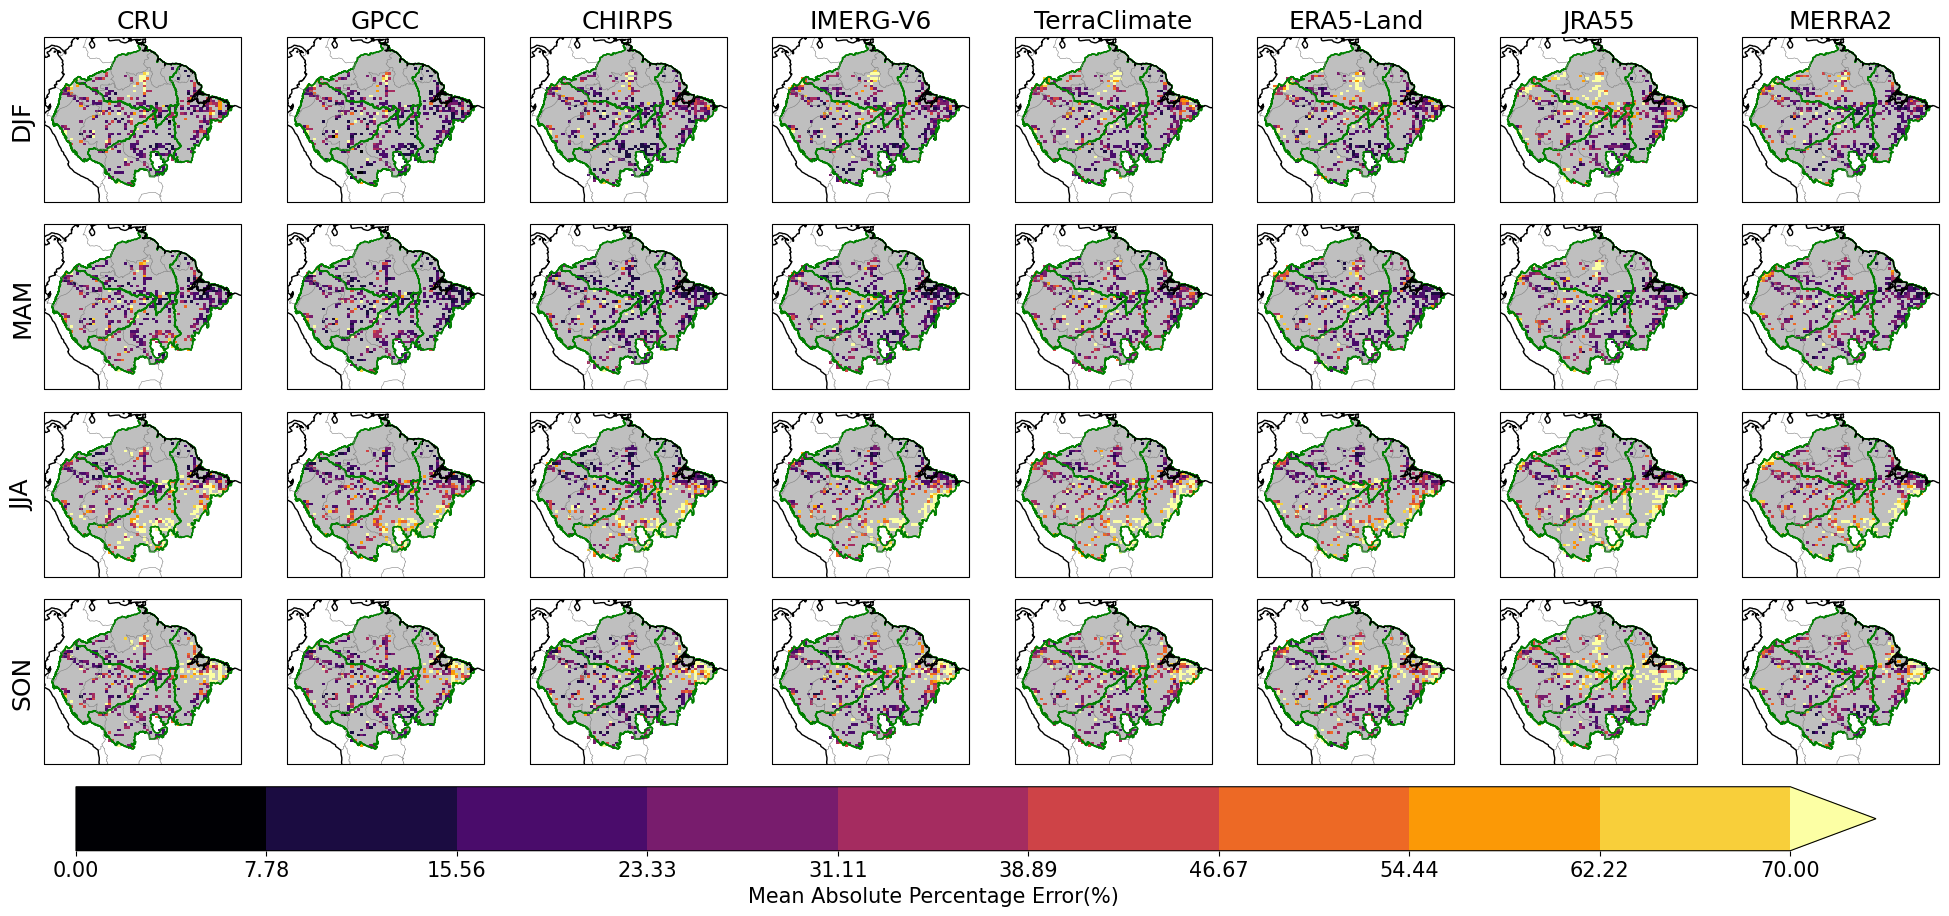

In [ ]:
#plot each dataset and each season
fig, axes = plt.subplots(ncols=len(datasets), nrows=4, figsize=(20, 8), subplot_kw={'projection': proj})
#create cax in the bottom of the figure
cax = fig.add_axes([0.05, -0.08, 0.9, 0.08])

fig.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar)
for i, name in enumerate(datasets_names):
    for j in range(4):
        ax = axes[j, i]
        ds = metrics_dict_05[name]
        ds.sel(season=seasons[j])[var].plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels, extend=extend_cbar)
        ax.add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='green', linewidth=1, zorder=-30,alpha=0.5)

        # Add a title for each subplot
        #ax.set_title(datasets_names[i])
        # Remove x and y labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.set_extent([-81, -42, -20, 11])
        ax.coastlines()

        if i == 0:
            ax.set_ylabel(seasons[j], fontsize=18)
        if j == 0:
            ax.set_title(datasets_names[i], fontsize=18)


plt.tight_layout()

In [ ]:
df_metrics.groupby(['Region', 'Dataset', 'season']).mean()#.reset_index()

lat        lon      corr        rmse  \
Region  Dataset      season                                              
Eastern CHIRPS       DJF    -3.563776 -49.638605  0.663999   68.450493   
                     JJA    -3.563776 -49.638605  0.617273   24.362687   
                     MAM    -3.563776 -49.638605  0.632933   67.202520   
                     SON    -3.563776 -49.638605  0.655309   26.743598   
        CRU          DJF    -3.717742 -49.822581  0.526192   74.177816   
...                               ...        ...       ...         ...   
Western MERRA2       SON    -4.175439 -70.126096  0.219007   65.812228   
        TerraClimate DJF    -3.508690 -71.652738  0.254460   86.034883   
                     JJA    -3.508690 -71.652738  0.130585   83.454021   
                     MAM    -3.508690 -71.652738  0.029608  101.883286   
                     SON    -3.508690 -71.652738  0.218634   71.390888   

                                   mae        mape       kge       nse  
Region  Dataset      season                                             
Eastern CHIRPS       DJF     54.624761   26.480766  0.523809 -0.197199  
                     JJA     19.801724  121.055487  0.339747 -1.171028  
                     MAM     53.617216   20.432197  0.505960 -0.231073  
                     SON     21.340621  106.841071  0.309095 -1.198639  
        CRU          DJF     61.608758   29.556449  0.353188 -0.405314  
...                                ...         ...       ...       ...  
Western MERRA2       SON     55.947359   33.386167  0.091301 -2.882613  
        TerraClimate DJF     71.494378   39.648287  0.094514 -3.119444  
                     JJA     69.102545   46.650324 -0.185237 -5.085184  
                     MAM     83.867149   37.002321 -0.121676 -3.637857  
                     SON     58.697238   50.837076  0.045821 -3.042002  

[128 rows x 8 columns]

In [ ]:
df_metrics_mean = df_metrics.groupby(['Region', 'Dataset', 'season']).mean().reset_index()#.set_index('Dataset').groupby('Region')
df_metrics_mean = df_metrics_mean.set_index('Dataset').groupby(['Region', 'season'])
#get a table with the best dataset for each metric and region
metrics_min = ['rmse','mae','mape']
metrics_max = ['corr','kge','nse']
df_metrics_best = df_metrics_mean[metrics_max].idxmax()
df_metrics_best[metrics_min] = df_metrics_mean[metrics_min].idxmin() 
df_metrics_best
#df_metrics_mean[['corr','rmse','mae','mape','kge','nse','pbias']].reset_index().set_index('Dataset').groupby('Region').idxmax()

corr     kge       nse    rmse     mae       mape
Region   season                                                     
Eastern  DJF     CHIRPS    GPCC      GPCC    GPCC    GPCC       GPCC
         JJA     CHIRPS  CHIRPS      GPCC    GPCC    GPCC  ERA5-Land
         MAM     CHIRPS    GPCC  IMERG-V6    GPCC    GPCC       GPCC
         SON     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
Northern DJF     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
         JJA     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     CHIRPS
         MAM     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     CHIRPS
         SON     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     CHIRPS
Southern DJF     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     CHIRPS
         JJA     CHIRPS    GPCC      GPCC    GPCC    GPCC       GPCC
         MAM     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
         SON     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
Western  DJF     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     CHIRPS
         JJA     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
         MAM     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS       GPCC
         SON     CHIRPS  CHIRPS    CHIRPS  CHIRPS  CHIRPS     MERRA2